In [1]:
!pip install tensorflow-addons

     |████████████████████████████████| 679 kB 23.8 MB/s 


In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals


In [3]:
import tensorflow as tf

# We'll generate plots of attention in order to see which parts of an image
# our model focuses on during captioning
import matplotlib.pyplot as plt

# Scikit-learn includes many helpful utilities
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import re
import numpy as np
import os
import time
import json
from glob import glob
from PIL import Image
import pickle

In [4]:
annotation_zip = tf.keras.utils.get_file('captions.zip',
                                          cache_subdir=os.path.abspath('.'),
                                          origin = 'http://images.cocodataset.org/annotations/annotations_trainval2014.zip',
                                          extract = True)
annotation_file = os.path.dirname(annotation_zip)+'/annotations/captions_train2014.json'

name_of_zip = 'train2014.zip'
if not os.path.exists(os.path.abspath('.') + '/' + name_of_zip):
  image_zip = tf.keras.utils.get_file(name_of_zip,
                                      cache_subdir=os.path.abspath('.'),
                                      origin = 'http://images.cocodataset.org/zips/train2014.zip',
                                      extract = True)
  PATH = os.path.dirname(image_zip)+'/train2014/'
else:

  PATH = os.path.abspath('.')+'/train2014/'

13510574080/13510573713 [==============================] - 328s 0us/step


In [5]:
print(PATH)
!wget https://s3.amazonaws.com/cvmlp/vqa/mscoco/vqa/v2_Questions_Train_mscoco.zip
! unzip -a v2_Questions_Train_mscoco.zip
!wget https://s3.amazonaws.com/cvmlp/vqa/mscoco/vqa/v2_Annotations_Train_mscoco.zip
! unzip -a v2_Annotations_Train_mscoco.zip

/content/train2014/
--2021-07-26 14:19:50--  https://s3.amazonaws.com/cvmlp/vqa/mscoco/vqa/v2_Questions_Train_mscoco.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.141.112
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.141.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7239401 (6.9M) [application/zip]
Saving to: ‘v2_Questions_Train_mscoco.zip’

v2_Questions_Train_ 100%[===================>]   6.90M  --.-KB/s    in 0.1s    

2021-07-26 14:19:51 (71.1 MB/s) - ‘v2_Questions_Train_mscoco.zip’ saved [7239401/7239401]

Archive:  v2_Questions_Train_mscoco.zip
  inflating: v2_OpenEnded_mscoco_train2014_questions.json  [text]  
--2021-07-26 14:19:51--  https://s3.amazonaws.com/cvmlp/vqa/mscoco/vqa/v2_Annotations_Train_mscoco.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.141.112
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.141.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21708861 (21M

In [6]:
import collections
import operator
# read the json file
annotation_file = 'v2_mscoco_train2014_annotations.json'
with open(annotation_file, 'r') as f:
    annotations = json.load(f)

# storing the captions and the image name in vectors
all_answers = []
all_answers_qids = []
all_img_name_vector = []
all_accepted_answers = []
for annot in annotations['annotations']:
#     print(annot)
#     break
    ans_dic = collections.defaultdict(int)
    for each in annot['answers']:
      diffans = each['answer']
      if diffans in ans_dic:
        #print(each['answer_confidence'])
        if each['answer_confidence']=='yes':
          ans_dic[diffans]+=4
        if each['answer_confidence']=='maybe':
          ans_dic[diffans]+= 2
        if each['answer_confidence']=='no':
          ans_dic[diffans]+= 1
      else:
        if each['answer_confidence']=='yes':
          ans_dic[diffans]= 4
        if each['answer_confidence']=='maybe':
          ans_dic[diffans]= 2
        if each['answer_confidence']=='no':
          ans_dic[diffans]= 1
#     print(ans_dic.items()) 
#     break
    all_accepted_answers.append(['<start> '+a[0] +' <end>' for a in ans_dic.items()])
    most_fav = max(ans_dic.items(), key=operator.itemgetter(1))[0]
    #print(most_fav)
    caption = '<start> ' + most_fav + ' <end>' #each['answer']
    
    image_id = annot['image_id']
    question_id = annot['question_id']
    full_coco_image_path = PATH + 'COCO_train2014_' + '%012d.jpg' % (image_id)

    all_img_name_vector.append(full_coco_image_path)
    all_answers.append(caption)
    all_answers_qids.append(question_id)

In [7]:
len(all_answers)


443757

In [8]:
# read the json file
question_file = 'v2_OpenEnded_mscoco_train2014_questions.json'
with open(question_file, 'r') as f:
    questions = json.load(f)

# storing the captions and the image name in vectors
question_ids =[]
all_questions = []
all_img_name_vector_2 = []

for annot in questions['questions']:
    caption = '<start> ' + annot['question'] + ' <end>'
    image_id = annot['image_id']
    full_coco_image_path = PATH + 'COCO_train2014_' + '%012d.jpg' % (image_id)

    all_img_name_vector_2.append(full_coco_image_path)
    all_questions.append(caption)
    question_ids.append(annot['question_id'])

In [9]:
print(len(all_img_name_vector),len(all_answers), len(all_answers_qids))
print(all_img_name_vector[10:15],all_answers[10:15], all_answers_qids[10:15])
print(len(all_img_name_vector), len(all_questions) , len(question_ids))
print(all_img_name_vector_2[10:15],all_questions[10:15], question_ids[10:15])

443757 443757 443757
['/content/train2014/COCO_train2014_000000393221.jpg', '/content/train2014/COCO_train2014_000000393221.jpg', '/content/train2014/COCO_train2014_000000393221.jpg', '/content/train2014/COCO_train2014_000000393223.jpg', '/content/train2014/COCO_train2014_000000393223.jpg'] ['<start> yes <end>', '<start> yes <end>', '<start> contrail <end>', '<start> yes <end>', '<start> white and purple <end>'] [393221000, 393221001, 393221002, 393223000, 393223001]
443757 443757 443757
['/content/train2014/COCO_train2014_000000393221.jpg', '/content/train2014/COCO_train2014_000000393221.jpg', '/content/train2014/COCO_train2014_000000393221.jpg', '/content/train2014/COCO_train2014_000000393223.jpg', '/content/train2014/COCO_train2014_000000393223.jpg'] ['<start> Is the sky blue? <end>', '<start> Is there snow on the mountains? <end>', '<start> What is the white streak? <end>', '<start> Is the window open? <end>', '<start> What color is the toothbrush? <end>'] [393221000, 393221001, 39

In [10]:
# shuffling the captions and image_names together
# setting a random state


train_answers, train_questions, img_name_vector,train_accepted_answers = shuffle(all_answers,all_questions,
                                          all_img_name_vector,all_accepted_answers,
                                          random_state=20)

# selecting the first 30000 captions from the shuffled set
num_examples = 7500
train_answers = train_answers[:num_examples]
train_questions = train_questions[:num_examples]
img_name_vector = img_name_vector[:num_examples]
train_accepted_answers = train_accepted_answers[:num_examples]
print(img_name_vector[0],train_questions[0],train_answers[0])

print(len(img_name_vector),len(train_questions),len(train_answers))

/content/train2014/COCO_train2014_000000260702.jpg <start> Where was this picture taken? <end> <start> tennis court <end>
7500 7500 7500


In [11]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    #224 x 224 for VGG 299x299 for Inception
    img = tf.image.resize(img, (224, 224))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img

In [12]:
# This will find the maximum length of any question in our dataset
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

In [13]:
# choosing the top 10000 words from the vocabulary
top_k = 10000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(train_questions)
train_question_seqs = tokenizer.texts_to_sequences(train_questions)

#new edit
print(tokenizer.word_index)
ques_vocab = tokenizer.word_index
#print(train_question_seqs)

{'<unk>': 1, '<start>': 2, '<end>': 3, 'the': 4, 'is': 5, 'what': 6, 'are': 7, 'this': 8, 'in': 9, 'on': 10, 'a': 11, 'of': 12, 'how': 13, 'many': 14, 'color': 15, 'there': 16, 'man': 17, 'does': 18, 'people': 19, 'picture': 20, 'to': 21, 'wearing': 22, 'where': 23, 'kind': 24, 'these': 25, 'or': 26, 'it': 27, 'have': 28, 'person': 29, 'you': 30, 'do': 31, 'photo': 32, 'doing': 33, 'type': 34, 'they': 35, 'be': 36, 'animal': 37, 'holding': 38, 'woman': 39, 'room': 40, 'for': 41, 'he': 42, 'train': 43, 'at': 44, 'his': 45, 'can': 46, 'that': 47, 'which': 48, 'see': 49, 'shirt': 50, 'animals': 51, 'sign': 52, 'playing': 53, 'dog': 54, 'bus': 55, 'food': 56, 'cat': 57, 'water': 58, 'right': 59, "man's": 60, 'made': 61, 'an': 62, 'any': 63, 'plane': 64, 'was': 65, 'sport': 66, 'plate': 67, 'number': 68, 'sitting': 69, 'table': 70, 'being': 71, 'why': 72, 'with': 73, 'taken': 74, 'standing': 75, 'shown': 76, 'all': 77, 'left': 78, 'white': 79, 'boy': 80, 'top': 81, 'from': 82, 'sky': 83, 'h

In [14]:
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

In [15]:
# creating the tokenized vectors
train_question_seqs = tokenizer.texts_to_sequences(train_questions)

In [16]:
# padding each vector to the max_length of the captions
# if the max_length parameter is not provided, pad_sequences calculates that automatically
question_vector = tf.keras.preprocessing.sequence.pad_sequences(train_question_seqs, padding='post')
#cap_vector

In [17]:
# calculating the max_length
# used to store the attention weights
max_length = calc_max_length(train_question_seqs)
print(max_length)

#new edit
max_q = max_length

22


In [18]:
 #considering all answers to be part of ans vocab
from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

# define example
data = train_answers
values = array(data)
# print(values[:10])

# integer encode
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(values)
#print(integer_encoded)

onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
print(onehot_encoded)

#new edit
ans_vocab = {l: i for i, l in enumerate(label_encoder.classes_)}
# print(ans_vocab)

answer_vector = onehot_encoded

#new edit
len_ans_vocab = len(ans_vocab)

# print(answer_vector)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [19]:
print(len(question_vector[0]), len(answer_vector))


22 7500


In [20]:
img_name_train, img_name_val, question_train, question_val,answer_train, answer_val  = train_test_split(img_name_vector,
                                                                    question_vector,
                                                                    answer_vector,
                                                                    test_size=0.2,
                                                                    random_state=0)

In [21]:
print(len(img_name_train), len(img_name_val), len(question_train), len(question_val),len(answer_train), len(answer_val))


6000 1500 6000 1500 6000 1500


In [22]:
x = []
for i in img_name_train:
  x.append(load_image(i))


In [23]:
image_train = np.array(x)
print(image_train.shape)

(6000, 224, 224, 3)


In [24]:
x = []
for i in img_name_val:
  x.append(load_image(i))

image_val = np.array(x)
print(image_val.shape)

(1500, 224, 224, 3)


In [25]:
import numpy as np
from tensorflow import reshape
from tensorflow.keras import Model
import tensorflow_addons as tfa
from keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Embedding, LSTM, Activation,ZeroPadding1D,Conv2D

In [31]:
def create_model():
    input_pri = tf.keras.layers.Input(shape = (224, 224, 3), name = 'Input1') 
    input_sec = tf.keras.layers.Input(shape = (max_q,1), name = 'Input2')
        
    mouth_1 = Sequential([
        tf.keras.layers.Conv2D(64, (3,3), padding='valid'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='valid'),
        tf.keras.layers.Conv2D(32,(4,4), padding='valid'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='valid'),
        tf.keras.layers.Conv2D(16,(5,5), padding='valid'),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='valid'),
        tf.keras.layers.Flatten()
        ],name='Head1')
    
    mouth_2 = Sequential([
        tf.keras.layers.LSTM(16 , return_sequences=True, input_shape=(max_q,1)),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LSTM(8 ,return_sequences=True, input_shape=(16,1)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.LSTM(4 ,return_sequences=True, input_shape=(8,1)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Flatten()
        ],name='Head2')
    
    input_tir = mouth_1(input_pri)
    input_qua = mouth_2(input_sec)

    input_final_concat = tf.keras.layers.Concatenate()([input_qua, input_tir])

    num_columns = 10088
    

    stomach = tf.keras.Sequential([
    tf.keras.layers.Input(num_columns),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tfa.layers.WeightNormalization(tf.keras.layers.Dense(1024, activation="relu")),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tfa.layers.WeightNormalization(tf.keras.layers.Dense(256, activation="relu")),
    tf.keras.layers.BatchNormalization(), 
    tf.keras.layers.Dropout(0.5),
    tfa.layers.WeightNormalization(tf.keras.layers.Dense(256, activation="relu")),
    tf.keras.layers.BatchNormalization(), 
    tf.keras.layers.Dropout(0.5),
    tfa.layers.WeightNormalization(tf.keras.layers.Dense(1024, activation="relu")),        
    ],name='stomach')
    
    input_five = stomach(input_final_concat)

    input_qua_avg = tf.keras.layers.Concatenate()([input_qua, input_five])
    num_columns_1 = 1112

    stomach2 = tf.keras.Sequential([
        tf.keras.layers.Input(num_columns_1),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),
        tfa.layers.WeightNormalization(tf.keras.layers.Dense(1104, kernel_initializer='lecun_normal', activation='selu')),
        tf.keras.layers.BatchNormalization(),
        tfa.layers.WeightNormalization(tf.keras.layers.Dense(1627, activation="softmax"))
        ],name='Head3')

    output = stomach2(input_qua_avg)
    
    
    model = Model(inputs = [input_pri, input_sec], outputs = output)
    model.compile(optimizer=tf.optimizers.Adam(),
                  loss=tf.losses.CategoricalCrossentropy(label_smoothing=0.0005),metrics=['accuracy']
                  )
    return model

In [ ]:
a = create_model()

In [ ]:
tf.keras.utils.plot_model(a,show_shapes=True)

In [27]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.1, verbose=1,mode='min',patience=3, min_lr=1E-6)
early_st = tf.keras.callbacks.EarlyStopping(monitor='loss', min_delta=1E-5, patience=5, verbose=1, mode='min',baseline=None, restore_best_weights=True)

In [32]:
model = create_model()
history = model.fit([image_train,question_train],answer_train, batch_size= 8, epochs=40,verbose=2,validation_data = ([image_val,question_val],answer_val),callbacks =[reduce_lr, early_st])

Epoch 1/40
750/750 - 78s - loss: 7.3611 - accuracy: 0.0953 - val_loss: 6.1845 - val_accuracy: 0.0980
Epoch 2/40
750/750 - 37s - loss: 5.6475 - accuracy: 0.1530 - val_loss: 6.0189 - val_accuracy: 0.1713
Epoch 3/40
750/750 - 37s - loss: 5.1651 - accuracy: 0.1753 - val_loss: 6.0452 - val_accuracy: 0.1320
Epoch 4/40
750/750 - 37s - loss: 4.8175 - accuracy: 0.1837 - val_loss: 5.7730 - val_accuracy: 0.1900
Epoch 5/40
750/750 - 37s - loss: 4.5824 - accuracy: 0.1872 - val_loss: 5.5985 - val_accuracy: 0.1920
Epoch 6/40
750/750 - 37s - loss: 4.3951 - accuracy: 0.2023 - val_loss: 5.5262 - val_accuracy: 0.2027
Epoch 7/40
750/750 - 37s - loss: 4.2730 - accuracy: 0.2010 - val_loss: 5.5945 - val_accuracy: 0.2140
Epoch 8/40
750/750 - 37s - loss: 4.1345 - accuracy: 0.2045 - val_loss: 5.5116 - val_accuracy: 0.1913
Epoch 9/40
750/750 - 37s - loss: 4.0494 - accuracy: 0.2077 - val_loss: 5.6112 - val_accuracy: 0.1853
Epoch 10/40
750/750 - 37s - loss: 3.9341 - accuracy: 0.2127 - val_loss: 5.6659 - val_accura

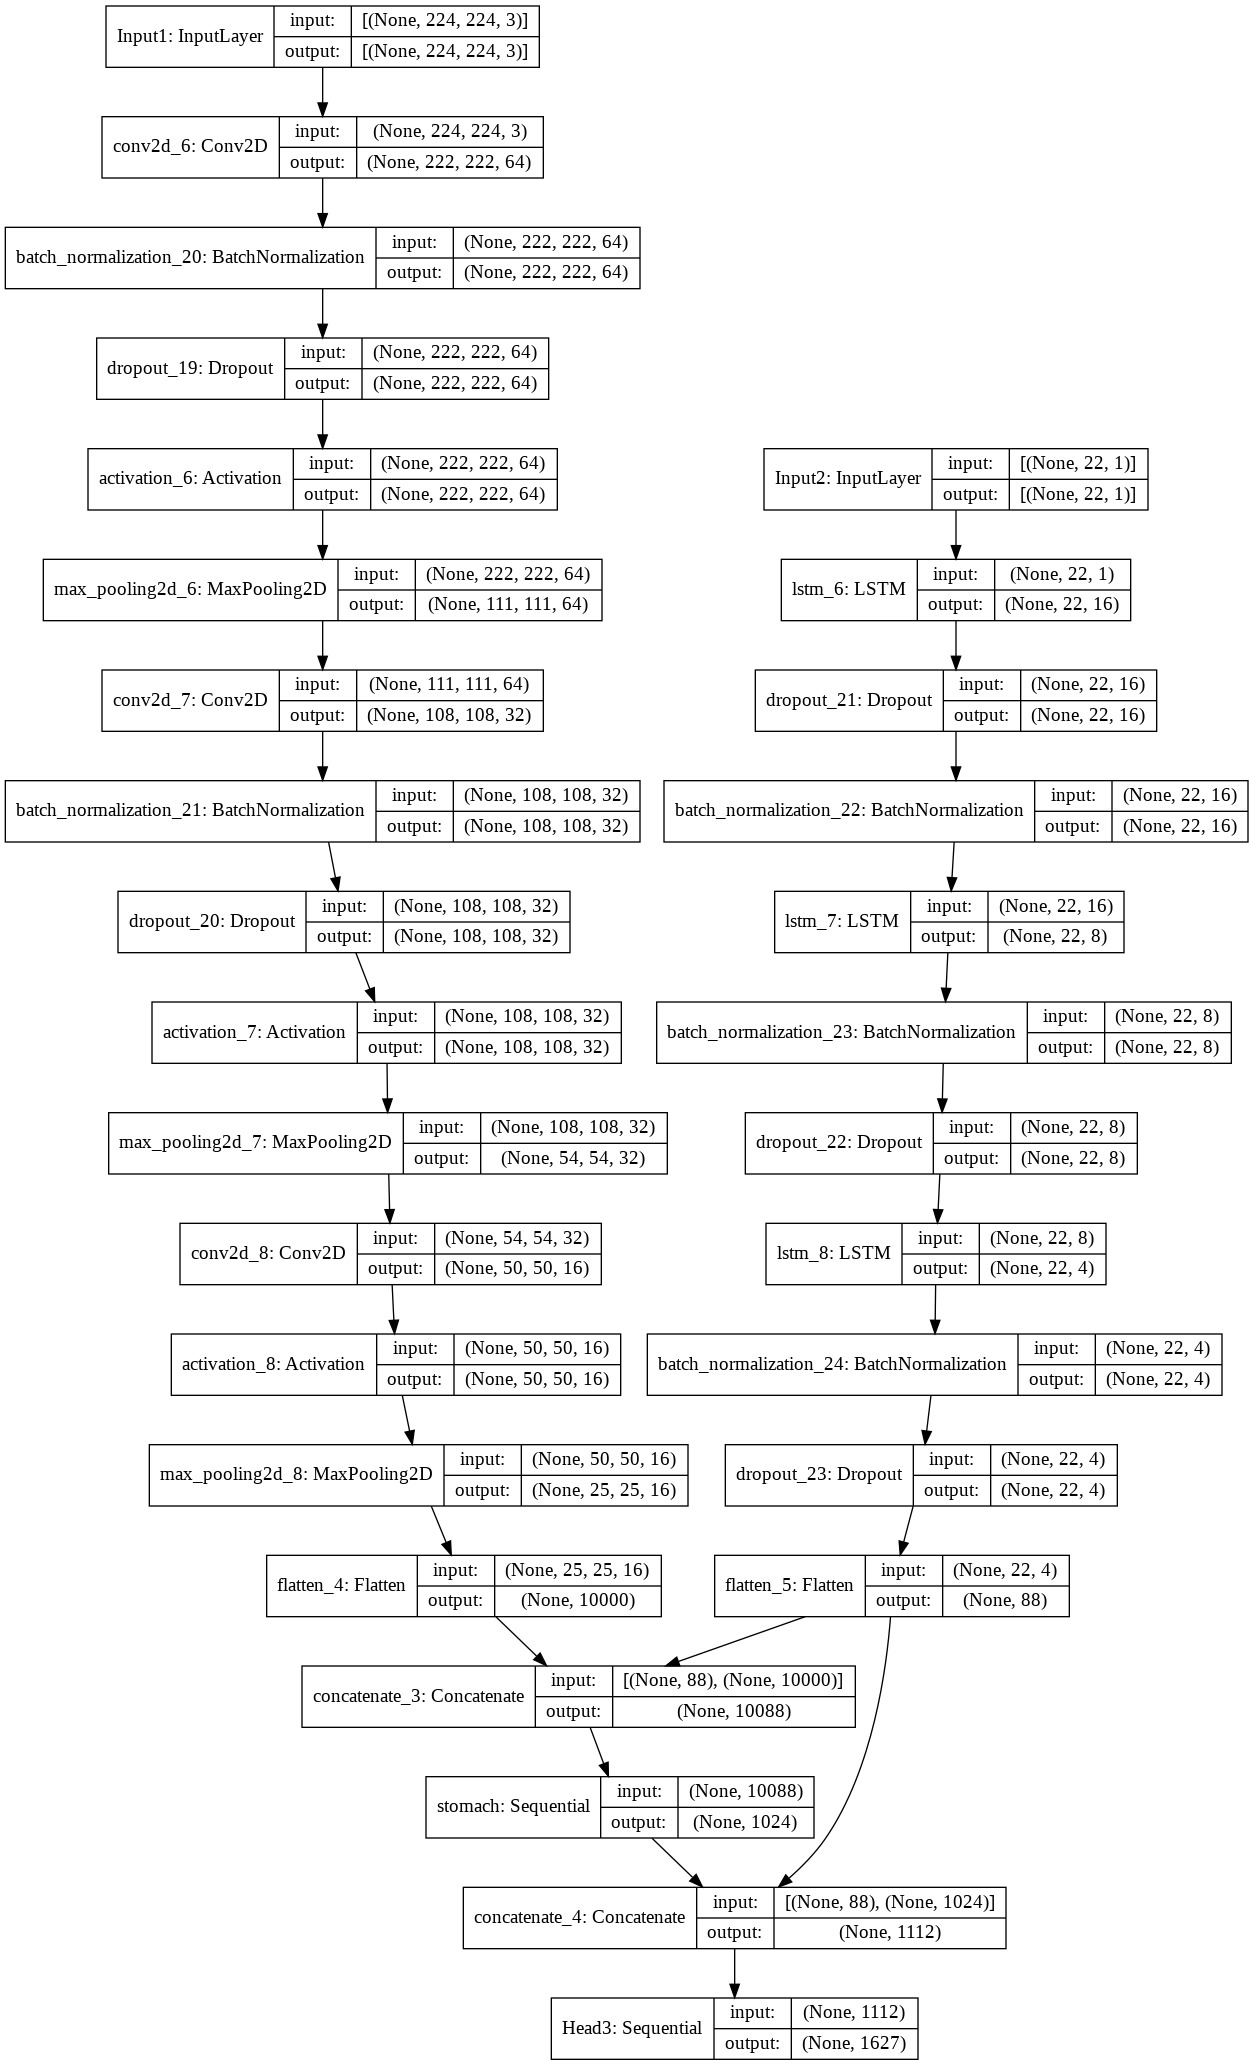

In [33]:
tf.keras.utils.plot_model(model,show_shapes=True)

In [35]:
model.save('model.h5')

In [37]:
new = tf.keras.models.load_model('model.h5')

In [34]:
reverse_word_map = dict(map(reversed, tokenizer.word_index.items()))

# Function takes a tokenized sentence and returns the words
def sequence_to_text(list_of_indices):
    # Looking up words in dictionary
    words = [reverse_word_map.get(letter) for letter in list_of_indices]
    return(words)

In [38]:
def test_model(a,b):
  ans = model.predict([a,b])
  ans = np.int8(ans == ans.max())
  ans = onehot_encoder.inverse_transform(ans)
  ans = label_encoder.inverse_transform(ans.ravel())
  question = list(map(sequence_to_text, b))

  return print(question),print(ans)

In [39]:
test_model(image_train[60:61],question_train[60:61])

[['<start>', 'is', 'this', 'breakfast', '<end>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']]
['<start> no <end>']


(None, None)

In [40]:
test_model(image_train[100:101],question_train[100:101])

[['<start>', 'how', 'many', 'double', 'cab', 'trucks', 'can', 'be', 'seen', '<end>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']]
['<start> 2 <end>']


(None, None)

In [41]:
test_model(image_train[1597:1598],question_train[1597:1598])

[['<start>', 'what', 'brand', 'is', 'the', 'ketchup', '<end>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']]
['<start> laying down <end>']


(None, None)

In [42]:
test_model(image_train[2259:2260],question_train[2259:2260])

[['<start>', 'are', 'the', 'blinds', 'shut', 'on', 'the', 'window', '<end>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']]
['<start> yes <end>']


(None, None)

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


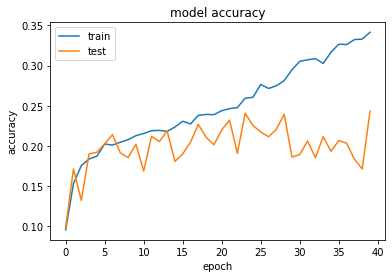

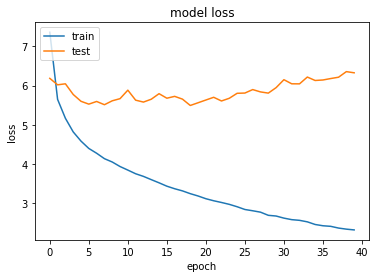

In [43]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()